In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import tri, cm

Definições Geométricas

In [2]:
Lx = 1
Nx = 100

Ly = 1
Ny = 100

Npoints = Nx*Ny

Definições do material

In [3]:
rho = 1
cv = 1
alpha = 1

Q = -4*rho*cv

In [4]:
# Boundary conditions
T1 = lambda x : (x - 0.5)**2 + 0.25 # bottom
T2 = lambda y : (y - 0.5)**2 + 0.25 # left
T3 = lambda x : (x - 0.5)**2 + 0.25 # top
T4 = lambda y : (y - 0.5)**2 + 0.25 # right

In [5]:
X = np.linspace(0, Lx, Nx, dtype = float)
Y = np.linspace(0, Ly, Ny, dtype = float)

Xv, Yv = np.meshgrid(X, Y)

X = np.reshape(Xv, Npoints)
Y = np.reshape(Yv, Npoints)

In [6]:
# nos de condicao de contorno
cc1 = np.arange(           start = 0,           stop = Nx,  step = 1) # bottom 
cc2 = np.arange(          start = Nx, stop = Npoints - Nx, step = Nx) # left
cc3 = np.arange(start = Npoints - Nx,      stop = Npoints,  step = 1) # top
cc4 = np.arange(    start = 2*Nx - 1, stop = Npoints - Nx, step = Nx) # right

cc = np.hstack([cc1,cc2,cc3,cc4])

In [7]:
## IEN 
# 0  ,  nx      ,  nx + 1 : type 1
# 0  ,  nx + 1  ,  1      : type 2

IEN = [
    [0, Nx + 1, Nx    ],
    [0,      1, Nx + 1]
]

for i in range(Ny - 1):
    
    for j in range(Nx - 2):
        IEN.append([IEN[-2][k] + 1 for k in range(3)])
        IEN.append([IEN[-2][k] + 1 for k in range(3)])

    if i < Ny - 2:
        IEN.append([IEN[0][k] + Nx*(i + 1) for k in range(3)])
        IEN.append([IEN[1][k] + Nx*(i + 1) for k in range(3)])


In [15]:
#form functions for 2D
def IENfunc(K, M, IEN):
    for IENelem in IEN:
        x_list = [X[elem] for elem in IENelem]
        y_list = [Y[elem] for elem in IENelem] #find direct slicing of x and y elems

        tri_matrix = [[1, X[IENelem[i]], Y[IENelem[i]]] for i in range(3)]

        tri_area = 0.5*np.linalg.det(tri_matrix)

        a_list = np.array([x_list[(i + 1)%3]*y_list[(i + 2)%3] - x_list[(i + 2)%3]*y_list[(i + 1)%3] for i in range(3)])
        b_list = np.array([y_list[(i + 1)%3] - y_list[(i + 2)%3] for i in range(3)])
        c_list = np.array([x_list[(i + 2)%3] - x_list[(i + 1)%3] for i in range(3)])

        melem = (tri_area/12)*np.array(([2, 1, 1],
                                      [1, 2, 1],
                                      [1, 1, 2]))
        
        kxelem = (alpha/(4*tri_area))*np.array([[b_list[i]*b_list[j] for i in range(3)] for j in range(3)])
        kyelem = (alpha/(4*tri_area))*np.array([[c_list[i]*c_list[j] for i in range(3)] for j in range(3)])

        # bi, bj, bk = b_list
        # ci, cj, ck = c_list

        # kxelem = (alpha/(4*tri_area))*np.array([[bi*bi,bi*bj,bi*bk],
        #                                     [bj*bi,bj*bj,bj*bk],
        #                                     [bk*bi,bk*bj,bk*bk]])
 
        # kyelem = (alpha/(4*tri_area))*np.array([[ci*ci,ci*cj,ci*ck],
        #                                     [cj*ci,cj*cj,cj*ck],
        #                                     [ck*ci,ck*cj,ck*ck]])

        kelem = kxelem + kyelem

        for ilocal in range(3):
            iglobal = IENelem[ilocal]

            for jlocal in range(3):
                jglobal = IENelem[jlocal]

                K[iglobal,jglobal] += kelem[ilocal,jlocal]
                M[iglobal,jglobal] += melem[ilocal,jlocal]

In [16]:
K  = np.zeros((Npoints, Npoints), dtype = float) 
M  = np.zeros((Npoints, Npoints), dtype = float)

IENfunc(K, M, IEN)

In [17]:
qvec = np.full(Npoints, Q/(rho*cv))

A = K.copy()
b = M@qvec

In [21]:
# imposicao das condicoes de contorno de Dirichlet
#-------------------------------------------------- 
# bottom boundary
for i in cc1:
 A[i,:] = 0.0
 A[i,i] = 1.0

# left boundary
for i in cc2:
 A[i,:] = 0.0
 A[i,i] = 1.0

# top boundary
for i in cc3:
 A[i,:] = 0.0
 A[i,i] = 1.0

# right boundary
for i in cc4:
 A[i,:] = 0.0
 A[i,i] = 1.0

In [22]:
# Dirichlet boundary conditions
#-------------------------------------------------- 
# bottom boundary
for i in cc1:
 b[i] = T1(X[i])

# left boundary
for i in cc2:
 b[i] = T2(Y[i])

# top boundary
for i in cc3:
 b[i] = T3(X[i])

# right boundary
for i in cc4:
 b[i] = T4(Y[i])

In [23]:
A_inv = np.linalg.inv(A)

In [24]:
T_vec = A_inv@b
T_mat = np.reshape(A_inv@b, (Nx, Ny))

In [25]:
triang = tri.Triangulation(X,Y)

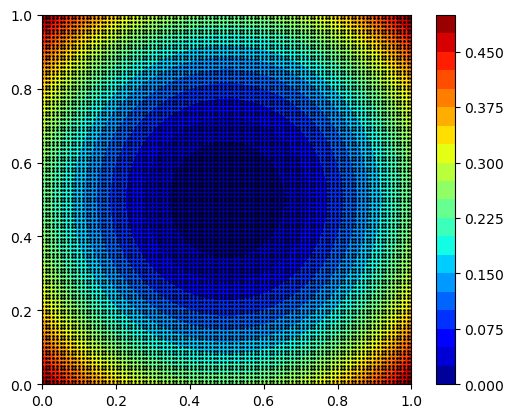

In [38]:
# For graphical purposes
Tmin = min(T_vec)
Tmax = max(T_vec)

# Temperature contourplot
ax = plt.axes()
ax.set_aspect('equal')
ax.triplot(triang,'k.', markersize = 2)
surf = ax.tricontourf(triang,T_vec,cmap='jet', levels = np.linspace(Tmin, Tmax, 21))
plt.colorbar(surf)
plt.show()

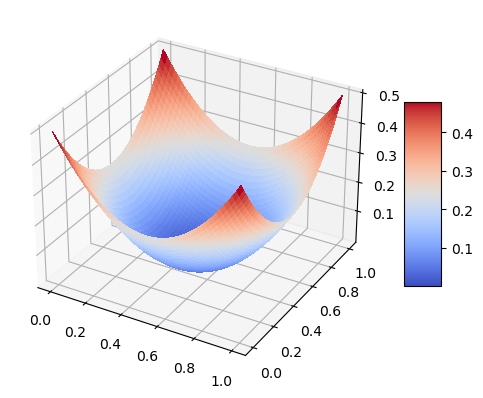

In [105]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
Xz = np.reshape(X, (Nx, Ny))
Yz = np.reshape(Y, (Nx, Ny))
Tz = np.reshape(T, (Nx, Ny))

# Plot the surface.
surf = ax.plot_surface(Xz, Yz, Tz, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()